In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Setup Using TPU Distributed Cluster

In [67]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Device: grpc://10.0.0.2:8470


2023-01-01 03:00:37.465219: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-01 03:00:37.465309: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2023-01-01 03:00:37.485564: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-01 03:00:37.485640: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


Number of replicas: 8
2.4.1


2023-01-01 03:00:37.784800: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 29520, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1672542037.784662658","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 29520, Output num: 0","grpc_status":3}


In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 64*strategy.num_replicas_in_sync
#BATCH_SIZE = 64 # for non-TPU use
IMAGE_SIZE = [180, 180]
EPOCHS = 50

# Combine Train, Validation, and Test Filenames to create a full similar distribution of training, val, and testing

#### As seen in the EDA, there is a severe imbalance of images amongst training, testing and validation.
- Validation only has 16 total images
- Training has 5216 total images
- Testing has 624 total images

As well, the classes are imbalanced amongst the sets:
- Validation set is a **50:50 split of Normal and Pneumonia**
- Training set is **74:26 Pneumonia:Normal**
- Testing set is **63:37 Pneumonia:Normal**. 

**The testing and validation need to have the same distrobution for the model to learn effectively.**

A much better distribution will have all the samples mixed together and then randomly split **60:20:20 for train:val:test**

## Combine the different files and randomly split them

In [69]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/test/*/*')))

print(f'The total number of files is {len(filenames)}')

2023-01-01 03:00:57.624669: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-01 03:00:57.691835: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-01 03:00:57.759967: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-01 03:00:57.836059: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-01 03:00:57.904369: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


The total number of files is 5856


2023-01-01 03:00:58.059716: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [70]:
# split the data into 60:40 for train:test+val
train_files, val_test_files = train_test_split(filenames, test_size=0.4,random_state=18)

In [71]:
# split the val_test_files to 50:50 to have a final split of 60:20:20 of train:val:test
val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=18)

## View the Distribution of Pneumonia and Normal in each set

In [72]:

pct_df = pd.DataFrame(columns = ['data_set', 'label', 'pct'], index = range(6))

totals = {'train':len(train_files), 'val':len(val_files), 'test':len(test_files)}

val_pneum_count = 0
val_norm_count = 0

re_pattern = '.*/(NORMAL|PNEUMONIA)/.*'

for file in val_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        val_norm_count += 1
    else:
        val_pneum_count += 1

pct_df.iloc[0, :] = ['val', 'NORMAL', round(100* val_norm_count / totals['val'], 1)]
pct_df.iloc[1, :] = ['val', 'PNEUMONIA', round(100* val_pneum_count / totals['val'], 1)]


test_pneum_count = 0
test_norm_count = 0
for file in test_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        test_norm_count += 1
    else:
        test_pneum_count += 1

pct_df.iloc[2, :] = ['test', 'NORMAL', round(100* test_norm_count / totals['test'], 1)]
pct_df.iloc[3, :] = ['test', 'PNEUMONIA', round(100* test_pneum_count / totals['test'], 1)]

train_pneum_count = 0
train_norm_count = 0
for file in train_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        train_norm_count += 1
    else:
        train_pneum_count += 1

pct_df.iloc[4, :] = ['train', 'NORMAL', round(100* train_norm_count / totals['train'], 1)]
pct_df.iloc[5, :] = ['train', 'PNEUMONIA', round(100* train_pneum_count / totals['train'], 1)]

In [73]:
PNEUM_COUNT = val_pneum_count + train_pneum_count + test_pneum_count
NORMAL_COUNT = val_norm_count + train_norm_count + test_norm_count
print(f'Normal: {NORMAL_COUNT}\nPneumonia: {PNEUM_COUNT}')

pct_df

Normal: 1583
Pneumonia: 4273


,data_set,label,pct
0,val,NORMAL,26.9
1,val,PNEUMONIA,73.1
2,test,NORMAL,27.6
3,test,PNEUMONIA,72.4
4,train,NORMAL,26.9
5,train,PNEUMONIA,73.1


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f077b507ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 535, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1267, in delete_iterator
    _ops.raise_from_not_ok_status(e, name)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 6862, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)
  File "<string>", line 3, in raise_from
tensorflow.python.framework.errors_impl.InvalidArgumentError: Resource input tensor contains an invalid device. This might happen when the client has connected to a different cluster, or some remote workers have been restarted. [Op:DeleteIterator]


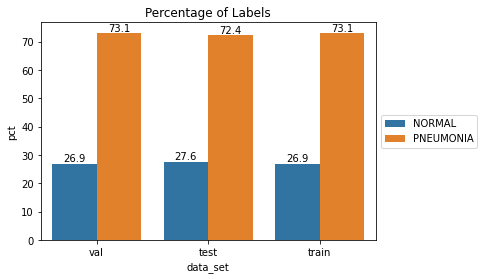

In [74]:
ax = sns.barplot(x=pct_df['data_set'], y=pct_df['pct'], hue=pct_df['label'])
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Percentage of Labels')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

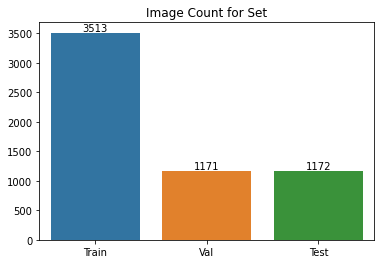

In [75]:
ax = sns.barplot(x=['Train', 'Val', 'Test'], y=[len(train_files), len(val_files), len(test_files)])
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Image Count for Set')
plt.show()

## New Distribution Analysis

This is a much better distribution as the percentage of Pneumonia and Normal is evenly distributed across the different sets. As well, there is a 60:20:20 distribution for train:val:test which should provide better results for modeling

In [76]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_files)

#view the file paths for training
print('----Training Files----')
for f in train_list_ds.take(5):
    print(f.numpy())
    

----Training Files----
b'gs://kds-2845a6faa1b1f808f7bb5a7d5e780b68df0961f27d3e1292043be381/chest_xray/train/PNEUMONIA/person509_virus_1025.jpeg'
b'gs://kds-2845a6faa1b1f808f7bb5a7d5e780b68df0961f27d3e1292043be381/chest_xray/train/PNEUMONIA/person671_bacteria_2564.jpeg'
b'gs://kds-2845a6faa1b1f808f7bb5a7d5e780b68df0961f27d3e1292043be381/chest_xray/train/PNEUMONIA/person957_virus_1629.jpeg'
b'gs://kds-2845a6faa1b1f808f7bb5a7d5e780b68df0961f27d3e1292043be381/chest_xray/test/PNEUMONIA/person81_bacteria_397.jpeg'
b'gs://kds-2845a6faa1b1f808f7bb5a7d5e780b68df0961f27d3e1292043be381/chest_xray/train/NORMAL/IM-0500-0001.jpeg'


In [77]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

print(f'Train Image Count: {TRAIN_IMG_COUNT}\nVal Image Count: {VAL_IMG_COUNT}\nTest Image Count: {TEST_IMG_COUNT}')

Train Image Count: 3513
Val Image Count: 1171
Test Image Count: 1172


## Pre Process the Data

In [78]:
# will label as 1 if pneumonia otherwise 0
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [79]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [80]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [81]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [82]:
y_train = []
for image, label in train_ds.take(TRAIN_IMG_COUNT):
    y_train.append(label)
    
print('Training Counts')
print(f'Pneumonia count: {np.sum(y_train)}\nNormal count: {TRAIN_IMG_COUNT - np.sum(y_train)}')

Training Counts


2023-01-01 03:03:04.263432: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 608695, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1672542184.263323391","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 608695, Output num: 0","grpc_status":3}


Pneumonia count: 2568
Normal count: 945


In [83]:
y_val = []
for image, label in val_ds.take(VAL_IMG_COUNT):
    y_val.append(label)
    
print('Validation Counts')
print(f'Pneumonia count: {np.sum(y_val)}\nNormal count: {VAL_IMG_COUNT - np.sum(y_val)}')

Validation Counts
Pneumonia count: 856
Normal count: 315


In [84]:
y_test = []
for image, label in test_ds.take(TEST_IMG_COUNT):
    y_test.append(label)
    
print('Test Counts')
print(f'Pneumonia count: {np.sum(y_test)}\nNormal count: {TEST_IMG_COUNT - np.sum(y_test)}')

2023-01-01 03:04:09.460963: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 24693, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1672542249.449368207","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 24693, Output num: 1","grpc_status":3}


Test Counts
Pneumonia count: 849
Normal count: 323


In [85]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [86]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


image_batch, label_batch = next(iter(train_ds))

2023-01-01 03:05:20.630617: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 29414, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1672542320.630528640","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 29414, Output num: 1","grpc_status":3}


## View Some of the Images

In [87]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

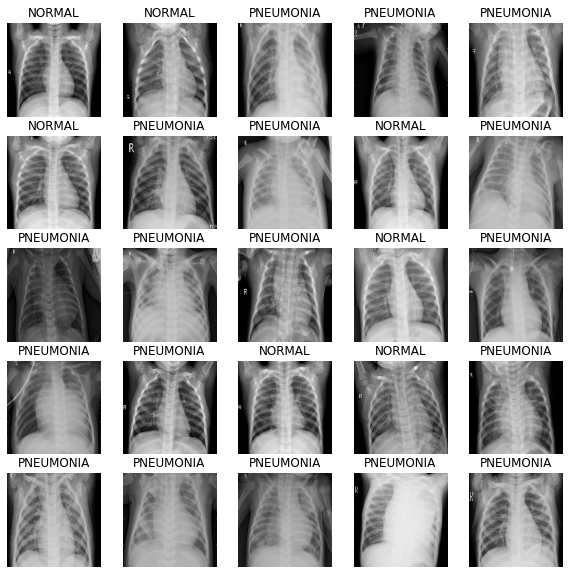

In [88]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Create Weights for the Image Class Imbalance

Because the percentage of Pneumonia images is so much higher than the Normal images, I will apply a weight towards the Normal images to make sure the model gives a stronger penalty to misclassification of Normal images.

In [89]:
initial_bias = np.log([PNEUM_COUNT/NORMAL_COUNT])
initial_bias

array([0.99299438])

In [90]:
weight_for_0 = (1 / NORMAL_COUNT)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / PNEUM_COUNT)*(TRAIN_IMG_COUNT)/2.0

In [91]:
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

Weight for class 0: 1.11
Weight for class 1: 0.41


In [92]:
# create some metrics for comparing on test results

def precision(y_test, y_pred):
    tp, fp = 0, 0
    
    for i in range(len(y_test)):
        if y_test[i] >= 0.5 and y_pred[i] >= 0.5:
            tp += 1
        elif y_test[i] < 0.5 and y_pred[i] >= 0.5:
            fp += 1
            
    return tp / (tp + fp)

def recall(y_test, y_pred):
    tp, fn = 0, 0
    
    for i in range(len(y_test)):
        if y_test[i] >= 0.5 and y_pred[i] >= 0.5:
            tp += 1
        elif y_test[i] >= 0.5 and y_pred[i] < 0.5:
            fn += 1
            
    return tp / (tp + fn)

def f1_score(y_test, y_pred):
    numerator = precision(y_test, y_pred) * recall(y_test, y_pred)
    denominator = precision(y_test, y_pred) + recall(y_test, y_pred)
    
    return 2 * (numerator / denominator)

## Try Four Different Pre-Trained Models

- VGG16
- InceptionV3
- ResNet50
- DenseNet201

## VGG-16

In [93]:
with strategy.scope():
    
    base_model = tf.keras.applications.vgg16.VGG16(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
    base_model.trainable = False
    
    x=base_model.output
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
             )

In [94]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("vgg16_xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [95]:
history = model.fit(
                   train_ds,
                   steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                   class_weight=class_weight,
                   callbacks=[checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/50


Exception ignored in: <function EagerResourceDeleter.__del__ at 0x7f077c4de5f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 289, in __del__
    self._handle, ignore_lookup_error=True)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 248, in destroy_resource_op
    _ops.raise_from_not_ok_status(e, name)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 6862, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)
  File "<string>", line 3, in raise_from
tensorflow.python.framework.errors_impl.InvalidArgumentError: Resource input tensor contains an invalid device. This might happen when the client has connected to a different cluster, or some remote workers have been restarted. [Op:DestroyResourceOp]
Exception ignored in: <function EagerResourceDeleter.__del__ at 

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_'+metric])
    ax[i].set_title(f'VGG-16 Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])
    

In [ ]:
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

In [59]:

y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)

print(y_preds[:10])

# for image, label in test_ds.take(TEST_IMG_COUNT):
#     y_test.append(label)
#     pred = model.predict(image)
#     y_preds.append(pred)
    

IndexError: list index out of range

## InceptionV3

In [39]:
with strategy.scope():
    
    base_model = tf.keras.applications.inception_v3.InceptionV3(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
    base_model.trainable = False
    
    x=base_model.output
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
             )

87916544/87910968 [==============================] - 1s 0us/step


In [40]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("inception_xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
                   train_ds,
                   steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                   class_weight=class_weight,
                   callbacks=[checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/50
6/6 [==============================] - 30s 3s/step - loss: 0.4441 - accuracy: 0.6261 - precision: 0.8177 - recall: 0.6278 - val_loss: 0.3987 - val_accuracy: 0.8301 - val_precision: 0.8939 - val_recall: 0.8725
Epoch 2/50
6/6 [==============================] - 1s 271ms/step - loss: 0.3110 - accuracy: 0.7782 - precision: 0.8985 - recall: 0.7840 - val_loss: 0.3710 - val_accuracy: 0.8379 - val_precision: 0.9521 - val_recall: 0.8202
Epoch 3/50
6/6 [==============================] - 1s 269ms/step - loss: 0.2288 - accuracy: 0.8394 - precision: 0.9387 - recall: 0.8379 - val_loss: 0.2979 - val_accuracy: 0.8711 - val_precision: 0.9486 - val_recall: 0.8694
Epoch 4/50
6/6 [==============================] - 1s 269ms/step - loss: 0.1926 - accuracy: 0.8589 - precision: 0.9506 - recall: 0.8506 - val_loss: 0.2610 - val_accuracy: 0.8896 - val_precision: 0.9608 - val_recall: 0.8850
Epoch 5/50
6/6 [==============================] - 1s 261ms/step - loss: 0.1878 - accuracy: 0.8756 - precision: 0.9

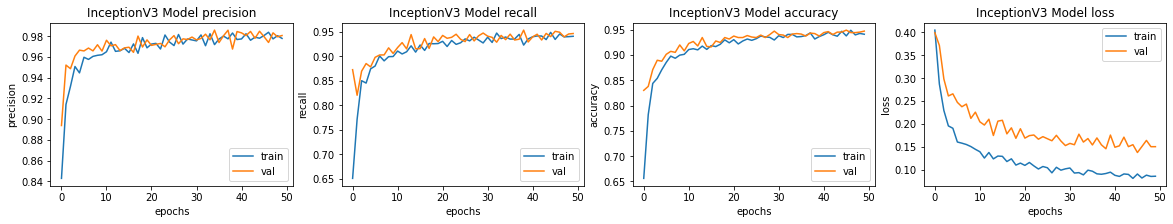

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_'+metric])
    ax[i].set_title(f'InceptionV3 Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])
    

## ResNet-50

In [42]:
with strategy.scope():
    
    base_model = tf.keras.applications.resnet50.ResNet50(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
    base_model.trainable = False
    
    x=base_model.output
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
             )

94773248/94765736 [==============================] - 0s 0us/step


In [43]:
ccheckpoint_cb = tf.keras.callbacks.ModelCheckpoint("resnet50_xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
                   train_ds,
                   steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                   class_weight=class_weight,
                   callbacks=[checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/50
6/6 [==============================] - 19s 2s/step - loss: 0.4523 - accuracy: 0.4161 - precision: 0.7147 - recall: 0.3350 - val_loss: 0.6528 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/50
6/6 [==============================] - 1s 254ms/step - loss: 0.4357 - accuracy: 0.5216 - precision: 0.7223 - recall: 0.5773 - val_loss: 0.7427 - val_accuracy: 0.2705 - val_precision: 1.0000 - val_recall: 0.0053
Epoch 3/50
6/6 [==============================] - 1s 237ms/step - loss: 0.4328 - accuracy: 0.4371 - precision: 0.7361 - recall: 0.3562 - val_loss: 0.6867 - val_accuracy: 0.5537 - val_precision: 0.6973 - val_recall: 0.6889
Epoch 4/50
6/6 [==============================] - 1s 257ms/step - loss: 0.4304 - accuracy: 0.5300 - precision: 0.7397 - recall: 0.5558 - val_loss: 0.6607 - val_accuracy: 0.7256 - val_precision: 0.7256 - val_recall: 1.0000
Epoch 5/50
6/6 [==============================] - 1s 234ms/step - loss: 0.4274 - accuracy: 0.5119 - precision: 0.7

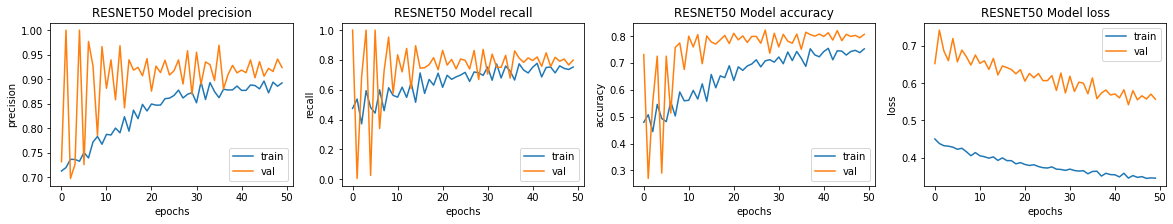

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_'+metric])
    ax[i].set_title(f'RESNET50 Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])
    

## DenseNet-201

In [45]:
with strategy.scope():
    
    base_model = tf.keras.applications.densenet.DenseNet201(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
    base_model.trainable = False
    
    x=base_model.output
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
             )

74842112/74836368 [==============================] - 0s 0us/step


In [46]:
ccheckpoint_cb = tf.keras.callbacks.ModelCheckpoint("densenet_xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
                   train_ds,
                   steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                   class_weight=class_weight,
                   callbacks=[checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/50
6/6 [==============================] - 46s 4s/step - loss: 0.4823 - accuracy: 0.6329 - precision: 0.7582 - recall: 0.7325 - val_loss: 0.7615 - val_accuracy: 0.4814 - val_precision: 0.9823 - val_recall: 0.2964
Epoch 2/50
6/6 [==============================] - 2s 319ms/step - loss: 0.3892 - accuracy: 0.5408 - precision: 0.8781 - recall: 0.4210 - val_loss: 0.4814 - val_accuracy: 0.8145 - val_precision: 0.9387 - val_recall: 0.7981
Epoch 3/50
6/6 [==============================] - 2s 306ms/step - loss: 0.3046 - accuracy: 0.7709 - precision: 0.8814 - recall: 0.7918 - val_loss: 0.3844 - val_accuracy: 0.8506 - val_precision: 0.9266 - val_recall: 0.8666
Epoch 4/50
6/6 [==============================] - 2s 305ms/step - loss: 0.2666 - accuracy: 0.8075 - precision: 0.9105 - recall: 0.8174 - val_loss: 0.3860 - val_accuracy: 0.8418 - val_precision: 0.9618 - val_recall: 0.8140
Epoch 5/50
6/6 [==============================] - 2s 295ms/step - loss: 0.2320 - accuracy: 0.8096 - precision: 0.9

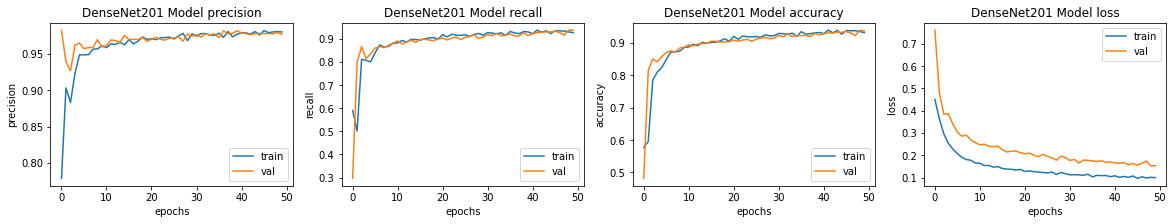

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_'+metric])
    ax[i].set_title(f'DenseNet201 Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])
    

## Try some Fine-Tuning

In [ ]:
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         return lr0 * 0.1 ** (epoch / s)
#     return exponential_decay_fn

# exponential_decay_fn = exponential_decay(0.01, 20)

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
# for _ in range(8):
    
#     with strategy.scope():
    
#         base_model = tf.keras.applications.inception_v3.InceptionV3(
#                 input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
#                 include_top=False,
#                 weights='imagenet'
#                 )
#         base_model.trainable = False
    
#         x=base_model.output
#         inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#         x = base_model(inputs, training=False)
#         x = tf.keras.layers.GlobalAveragePooling2D()(x)
#         x = tf.keras.layers.Dropout(0.3)(x)
#         x = tf.keras.layers.Dense(256)(x)
#         x = tf.keras.layers.BatchNormalization()(x)
#         x = tf.keras.layers.Dropout(0.3)(x)
#         outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#         model = tf.keras.Model(inputs, outputs)

    
    
#         METRICS = [
#             'accuracy',
#             tf.keras.metrics.Precision(name='precision'),
#             tf.keras.metrics.Recall(name='recall')
#             ]
    
#         model.compile(
#                 optimizer='adam',
#                 loss='binary_crossentropy',
#                 metrics=METRICS
#                  )
    
    
#     r = -4 * random.random()
#     learning_rate = 10 ** r

#     exponential_decay_fn = exponential_decay(learning_rate, 20)

#     lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#     print(f'Training: Learning Rate = {learning_rate}')
    
#     checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"xray_model_{learning_rate}.h5", save_best_only=True)

#     history = model.fit(
#                 train_ds,
#                 steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#                 epochs=25,
#                 validation_data=val_ds,
#                 validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#                 class_weight=class_weight,
#                 callbacks=[lr_scheduler, checkpoint_cb, early_stopping_cb])
    
#     fig, ax = plt.subplots(1, 4, figsize=(20, 3))
#     ax = ax.ravel()

#     for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#         ax[i].plot(history.history[metric])
#         ax[i].plot(history.history['val_'+metric])
#         ax[i].set_title(f'Model {metric}')
#         ax[i].set_xlabel('epochs')
#         ax[i].set_ylabel(metric)
#         ax[i].legend(['train', 'val'])
        
#     print(f'Training Complete for {learning_rate}\n\n\n')
    
#     test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
#     TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
#     test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#     test_ds = test_ds.batch(BATCH_SIZE)
    
#     results = model.evaluate(test_ds)
    
#     print(f'Test set results for {learning_rate}: {results}')
    
#     print('\n\n\n')

## Try on different number of hidden units and mini-batch sizes

In [ ]:
# for _ in range(4):
#     r = -2 **  random.random()
#     learning_rate = 10 ** r
#     for mini_batch_size in [128, 256, 512]:
#         for hidden_units in [64, 128, 256, 512]:
    
#             with strategy.scope():
    
#                 base_model = tf.keras.applications.inception_v3.InceptionV3(
#                     input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
#                     include_top=False,
#                     weights='imagenet'
#                     )
#                 base_model.trainable = False
    
#                 x=base_model.output
#                 inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#                 x = base_model(inputs, training=False)
#                 x = tf.keras.layers.GlobalAveragePooling2D()(x)
#                 x = tf.keras.layers.Dropout(0.3)(x)
#                 x = tf.keras.layers.Dense(hidden_units)(x)
#                 x = tf.keras.layers.BatchNormalization()(x)
#                 x = tf.keras.layers.Dropout(0.3)(x)
#                 outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#                 model = tf.keras.Model(inputs, outputs)

    
    
#                 METRICS = [
#                     'accuracy',
#                     tf.keras.metrics.Precision(name='precision'),
#                     tf.keras.metrics.Recall(name='recall')
#                     ]
    
#                 model.compile(
#                     optimizer='adam',
#                     loss='binary_crossentropy',
#                     metrics=METRICS
#                      )
    

#                 exponential_decay_fn = exponential_decay(learning_rate, 20)

#                 lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#                 print(f'Training: Learning Rate = {learning_rate}\nHidden Units = {hidden_units}\nMini Batch Size = {mini_batch_size}')
    
#                 label_lr = round(learning_rate, 3)
    
    
#                 checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"xray_model_{mini_batch_size}_{hidden_units}_{label_lr}.h5", save_best_only=True)

#                 BATCH_SIZE = mini_batch_size
    
#                 history = model.fit(
#                         train_ds,
#                         steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#                         epochs=50,
#                         validation_data=val_ds,
#                         validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#                         class_weight=class_weight,
#                         callbacks=[lr_scheduler, checkpoint_cb, early_stopping_cb])
    
#                 fig, ax = plt.subplots(1, 4, figsize=(20, 3))
#                 ax = ax.ravel()

#                 for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#                     ax[i].plot(history.history[metric])
#                     ax[i].plot(history.history['val_'+metric])
#                     ax[i].set_title(f'Model {metric}')
#                     ax[i].set_xlabel('epochs')
#                     ax[i].set_ylabel(metric)
#                     ax[i].legend(['train', 'val'])
        
#                     print(f'Training Complete\nLearning Rate = {learning_rate}\nHidden Units = {hidden_units}\nMini Batch Size = {mini_batch_size}\n\n\n')
    
#                 test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
#                 TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
#                 test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#                 test_ds = test_ds.batch(BATCH_SIZE)
    
#                 results = model.evaluate(test_ds)
    
#                 print(f'Test set results for {learning_rate}: {results}\n\n\n')
    


## Evaluate Model on Test Set

In [ ]:

# test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE)

# TEST_IMAGE_COUNT

In [ ]:
# results = model.evaluate(test_ds)

In [ ]:
# test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
# TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
# test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
# y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)

# len(y_preds)


### Try different Thresholds

In [ ]:
# from sklearn.metrics import classification_report

# y_preds_filtered = [1 if pred > 0.5 else 0 for pred in y_preds]

# class_report = classification_report(y_test, y_preds_filtered)
# print(class_report)

In [ ]:
# # build a function for AUC 
# def plot_auc(t_y, p_y):
    
#     fpr, tpr, threshold = roc_curve(t_y, p_y, pos_label=1)
#     plt.plot(fpr, tpr, color='red', lw=2)
#     plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
    
#     return plt.show()